# PW 1 - Practical work on SAR imaging : introduction to SAR data and interferometric processing
The aim of this PW is to get familiar with SAR data (high dynamic of the images, complex data with ampltidue and phase). After a first part on the visualization of such data and the understanding of the image content, the second part is dedicated to the processing of phase and interferometric data.

## 1. Analysis of a series of SAR images
In this part, we will have a look at a temporal series of 25 SAR images acquired [from 2015-10-06 to 2016-11-05](https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/PileLely_3072x1024RECALZ4.label), with a time delay of approximately 12 days.

By making use of these SAR images, we will see the main differences with respect to conventional natural images and develop some simple tools to visualize an image, interpret it and detect temporal changes.

In [ ]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py

import scipy
from scipy import signal
import scipy.signal
import scipy as spy
import scipy.fftpack
from scipy import ndimage
from scipy import special
import numpy as np
import math
import matplotlib.pyplot as plt
import mvalab as mvalab
from urllib.request import urlopen
import cmath
from google_drive_downloader import GoogleDriveDownloader as gdd


plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.max_open_warning'] = 30

--2024-06-04 17:58:08--  https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68071 (66K) [text/x-python]
Saving to: ‘mvalab.py’

mvalab.py           100%[===================>]  66.48K  --.-KB/s    in 0.01s   

2024-06-04 17:58:08 (4.54 MB/s) - ‘mvalab.py’ saved [68071/68071]



In [ ]:
# Download of the time series
webpage = 'https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/'
imagename = 'lely_tuple_multitemp.IMA'
imaslc = mvalab.imz2mat(webpage+imagename) # complex image

time_series_amp = np.abs(imaslc[0]) # taking an array of shape [n_rows,n_columns,n_dates] in amplitude format

imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.IMA
Nom compatible url
Nom compatible url
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.dim
Multitemporal image 25 data
Fichiers PC
Image  complex float
lecture .dim OK -> largeur:512 hauteur:512 profondeur:25
Debug 2 4 512
4 512 <f


### Question 1.1: display a SAR image
SAR images have a long-tailed distribution, making its dynamic range to be wide. Plot the image with matplotlib. What do you see?

It looks like an optical image with a low exposition and a low contrast. How can you improve the contrast of a SAR image, in order to have a more pleasant visualization?
Implement a function to plot a SAR image and comment the results obtained.

A usual way to do this, is the saturate all the values above a certain threshold (often chosen as the mean + 3 times the standard deviation of the image) and do a linear stretching for the other values.
Explain the effect of this processing and what you see in the resulting image.

### Answer 1.1
The effect of this processing is to reduce the differences between pixels and remove the outlier values that were obtained either by a high reflexion of an object or because of noise. By doing this treatment we make sure that we visualize has a good contrast where we better redistribute the gray values. In the resulting image we see a radar image obtained by a satillite. In this image we can distinguish different elements such as the large fields of farms, routes and water.

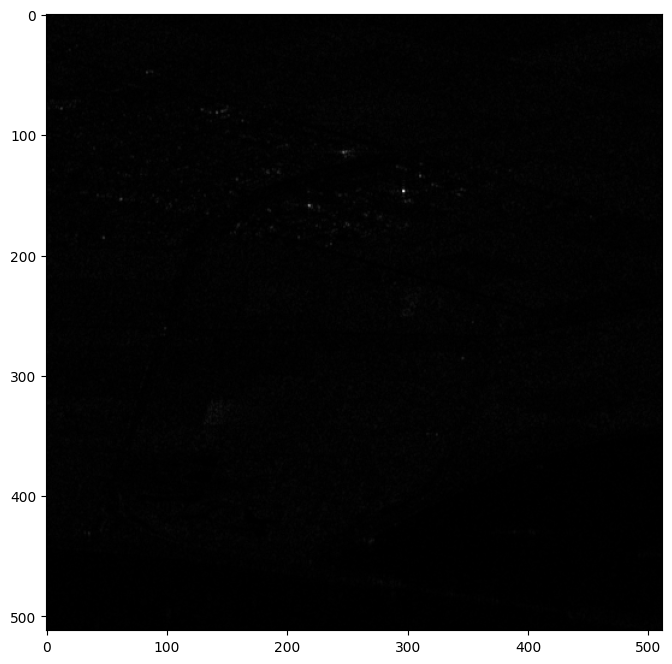

In [ ]:
plt.figure()
plt.imshow(time_series_amp[:,:,0],cmap='gray')
plt.show()

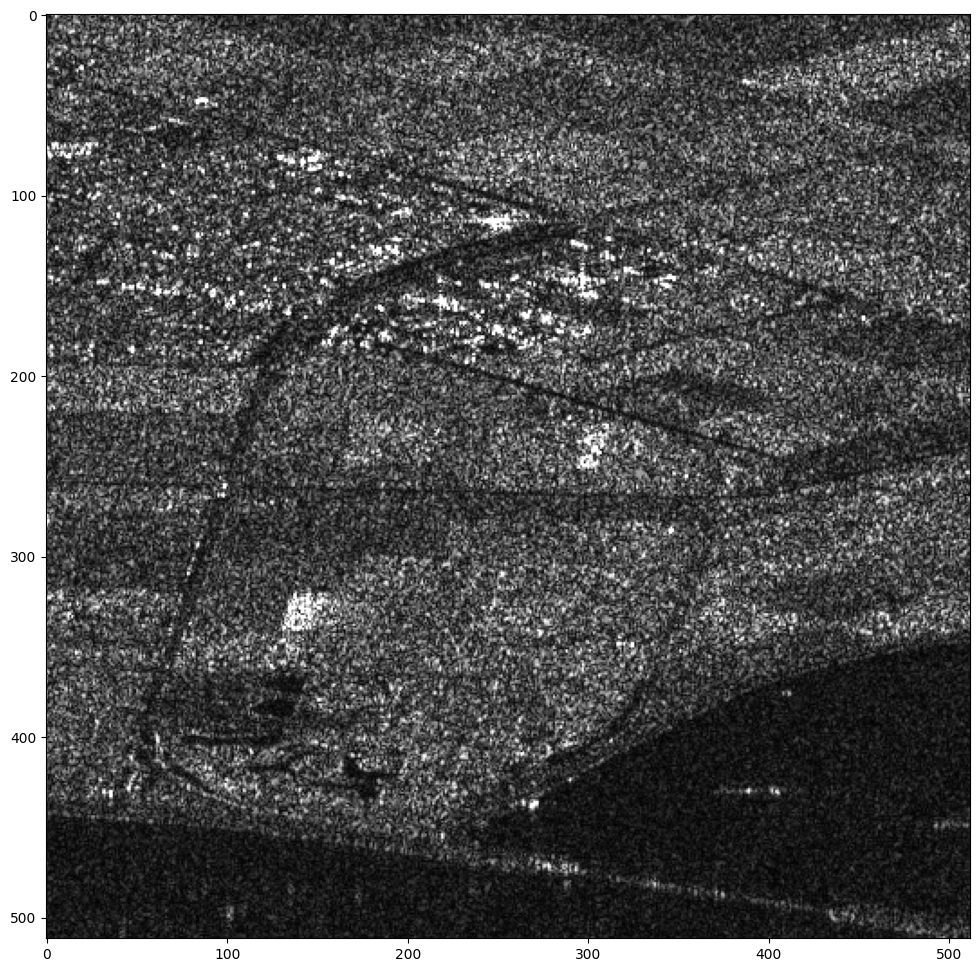

In [ ]:
# implement the following function to plot a SAR image
# you can use a threshold as mean + 3 sigma
# and the np.clip function

def plot_sar(ima):
  plt.figure(figsize=(12,12))
  t = ima.mean() +3*ima.std() # choose the appropriate theshold
  ima_to_plot = np.clip(ima,0,t)
  plt.imshow(ima_to_plot,cmap='gray') # display the saturated image
  plt.show()

plot_sar(time_series_amp[:,:,0])

### Question 1.2: Image orientation
Is the image in the correct geographic orientation?
Apply the proper flipping if necessary.

To see the corresponding optical image and find the correct flipping, you can have a look on Google Maps at [this location](https://goo.gl/maps/LQcd3Uz9U7qCoRrH6).

### Answer 1.2
No, this image is not in the right geographic orientation compared to what we see in Google Maps

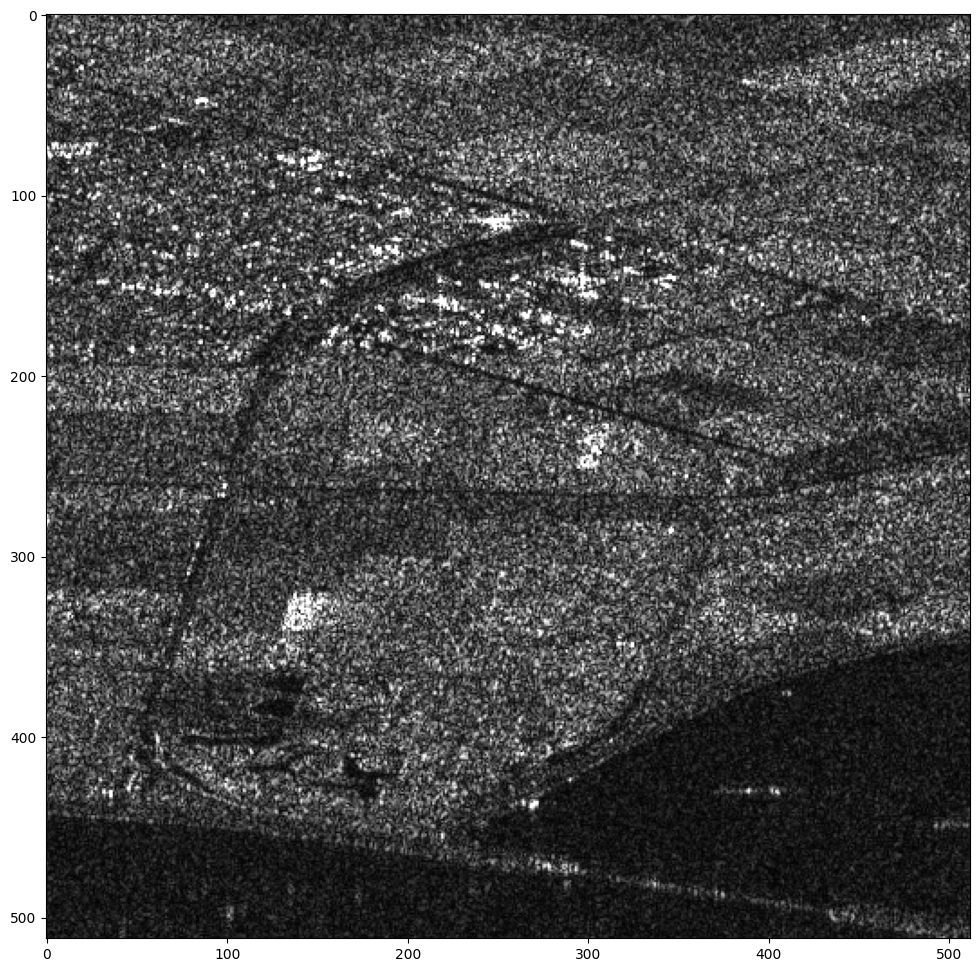

In [ ]:
plot_sar(time_series_amp[:,:,0])

In [ ]:
time_series_flipped = np.copy(time_series_amp)
time_series_flipped = np.flip(time_series_flipped,axis =0) # apply flipping if necessary using np.flip

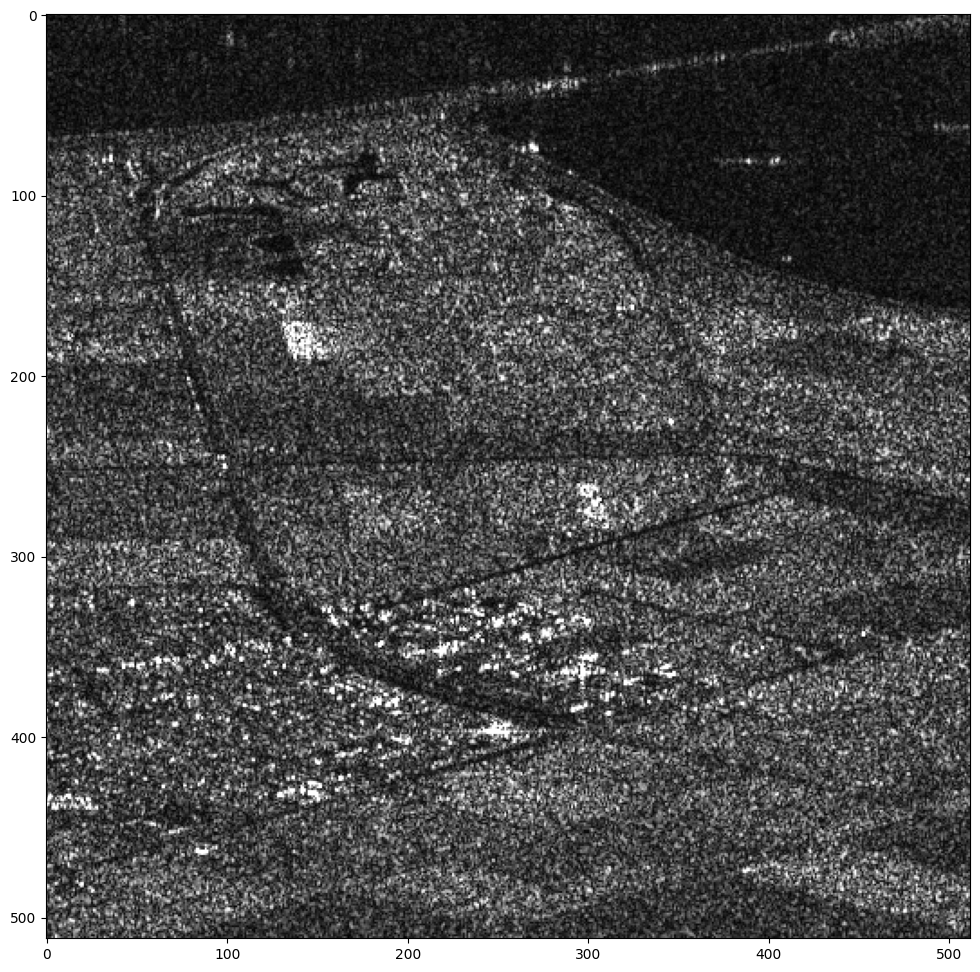

In [ ]:
plot_sar(time_series_flipped[:,:,0])

### Question 1.3: Interpretation of a SAR image
The image contains
- an urban area,
- agricultural fields,
- water

Explain the appearence of these objects in the SAR image.

### Answer 1.3
- urban area: This areas are charcaterized by the areas where we have sparking points ( pixels with high values). This is due to the rebound effect on the buildings leading to large returned energy on the sensor.
- agricultural fields: These fields are caracterized by a specific texture that is not too brilliant but not too dark as well. This due to the complex texture of the grass and trees present in these areas that reflects the incoming wave in a complex way leading to the specific texture that is associated with this kind of fields.
- water: The water appears as the black large areas in the image. This due to the fact that the surface of the water is perfectly flat which reflectes the incoming waves in an opposite direction of the sensor leading to messing signals there.
...

### Question 1.4: Multitemporal analysis and change detection
To detect changes occurring between three dates, images can be displayed in a false colour representation, each date being one channel of a RGB image. Implement the function ```plot_changes```.

Then, choose three dates from the multitemporal stack (indexes from 0 to 24). From the false colour representation, can you tell when a particular change has occurred? Explain how you can interpret it.

### Answer 1.4
Yes, we can see the changes in the color image. In fact, if there is no change the area will be gray (mix of levels of white ) meaning that all channels appears with the same intensity. As consequence whenever this condition do not hold we have changes. For instance the green field areas have values that are greater than the other two channels. Meaning that in that specific date associated to that channel we have brighter values meaning we have a change.

As we can see most of the changes occurers in the agriculture fields. The water and the city remains almost the same as when we visualize the gray images at a given date. This due to the nature of the agriculture fields that can change over time for instance if the grass has grown larger or the field has been cropped. In opposition the city and the water ramin almost identical over the short period of time

In [ ]:
def plot_changes(im1,im2,im3):
    threshold = np.min([im1.mean()+3*im1.std(),im2.mean()+3*im2.std(),im3.mean()+3*im3.std()]) # select a unique threshold for the three images
    # apply thresholding and shrinking of each image between [0;1] for RGB data
    im1 = np.clip(im1,0,threshold)
    im1 = im1/threshold
    im2 = np.clip(im2,0,threshold)
    im2 = im2/threshold
    im3 = np.clip(im3,0,threshold)
    im3 = im3/threshold
    image = np.concatenate([np.expand_dims(im1,axis=2),np.expand_dims(im2,axis=2),np.expand_dims(im3,axis=2)],axis=2) # create a false RGB image by stacking the three dates
    print(image.shape)
    plt.figure(figsize=(12,12))
    plt.imshow(image)
    plt.show()

In [ ]:
# choose three dates
idx1 = 1
idx2 = 10
idx3 = 15
im1 = time_series_flipped[:,:,idx1]
im2 = time_series_flipped[:,:,idx2]
im3 = time_series_flipped[:,:,idx3]

plot_sar(im1)
plot_sar(im2)
plot_sar(im3)
plot_changes(im1,im2,im3)

Output hidden; open in https://colab.research.google.com to view.

### Question 1.5: Create an image with isotropic pixels
The image pixels have the following size: $13.86[m]\times 2.3[m]$ in azimuth $\times$ range (approximately, pixel height is 5 times greater than pixel length). How can you create an image with approximately squared pixels?

PS : the range drection was the horizontal direction and the azimuth direction the vertical direction in the original image (before any flipping)

### Answer 1.5
We convolute our original image with a mask of proportion 1:5 this mask should average each five horzental pixels into one. That's why we choose the approriate mask. Thus leading to approximatly squared pixels

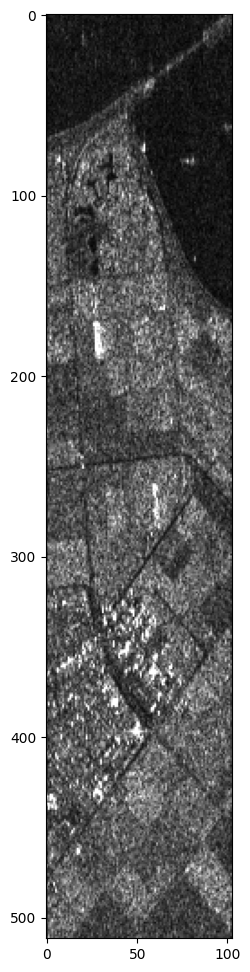

In [ ]:
ima_tmp = time_series_flipped[:,:,0]
mask = np.zeros((5,5))
mask[2] = np.ones((5,))/5
ima_filtered = scipy.signal.convolve2d(ima_tmp,mask,mode='same') # filter the image with the appropriate mask
ima_squared_pixels = ima_filtered[:,::5] # resample the filtered image
plot_sar(ima_squared_pixels)

## 2. Analysis of TerraSAR-X images acquired over the Paris area
In this part we will use an image of TerraSAR-X sensor (metric resolution) of Paris.
This is a temporal stack, you can choose the date you want.
(The questions are similar to the previous ones and will not be done during the PW but later as personal work).

In [ ]:
# 21 images from TerraSAR-X between 2009-01-24 and 2010-11-26
webpage='https://perso.telecom-paristech.fr/tupin/TPSAR/paris/'
image='PileiEiffeljavelRECALZ4RECSP.IMA'
im_slc_tsx_paris_liste=mvalab.imz2mat(webpage+image);
im_slc_tsx_paris = im_slc_tsx_paris_liste[0][:,:,0]
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visusar(np.abs(im_slc_tsx_paris))

Output hidden; open in https://colab.research.google.com to view.

### Question 2.1: interpretation
Check that you recognize the main buildings on this image.
What is the position of the track of the sensor relatively to this image ?

Explain the appearence of the following buildings in the amplitude image : Eiffel Tower, Maison de la radio, Pont de Bir-Hakeim (you can use a [satellite optic image on googlemaps](https://www.google.com/maps/place/Eiffel+Tower/@48.851143,2.2797819,447m/data=!3m1!1e3!4m5!3m4!1s0x47e66e2964e34e2d:0x8ddca9ee380ef7e0!8m2!3d48.8583701!4d2.2944813) to help you).



### Answer 2.1
In this image we can easily and quickly noitice two things : The Seine in the top of the image and the Tour Eiffel in the top right corner.

Upon inspecting the Eiffel Tower position and direction in the given image we conclude that the sensor is to the left. In fact, since the the top of the Eiffel Tower, which is the closest point to the sensor, is to the left we can conclude that the sensor was in the left direction.

The Tour suffers from layover with the ground. Thus its image is not that clear. In fact, a pixel corresponds to the Tour and the ground at the same time. Further more, we can see the shadow projected by the Maison de Radio to its right. And at last, the Pont is overall clear, with some more bright points that correspond to the vehicles going across it.

### Question 2.2: change detection
Identify and explain the appearence of some changing objects on Paris.

### Answer 2.2
Since Paris is almost a full urban zone, only few changes can be observed in the color map compared to the pervious example where we had agriculture fields. Most changes are concentrated to the boats in the river, that changed position. Also, the roads, with the movement of the vehicles. One or other building is marked as change, that may do to some construction/restoration.

In [ ]:
idx1 = 1
idx2 = 10
idx3 = 15
im1 = np.abs(im_slc_tsx_paris_liste[0][:,:,idx1])
im2 = np.abs(im_slc_tsx_paris_liste[0][:,:,idx2])
im3 = np.abs(im_slc_tsx_paris_liste[0][:,:,idx3])

plot_sar(im1)
plot_sar(im2)
plot_sar(im3)
plot_changes(im1,im2,im3)

Output hidden; open in https://colab.research.google.com to view.

## 3. SAR interferometry
In this part, the objective is to see the content of the phase of a SAR image and to do a simple processing chain to obtain an interferogram with topographic fringes.
You will be able to have a look to the optical image [on this link](https://g.page/ParcoEtna?share)

the situation is the following: you have 2 images obtained from 2 different sensors that are separted by a little and known distance

In [ ]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/interfero/Master.mat
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/interfero/Slave.mat
imageM='./Master.mat'
imageS='./Slave.mat'
imamaitre=mvalab.matlab2imz(imageM,'Master')
imaslave=mvalab.matlab2imz(imageS,'Slave')

imamaitre = imamaitre[0][1000:3000,:]
imaslave = imaslave[0][1000:3000,:]
ncolonnes=imamaitre.shape[1]
nlignes=imamaitre.shape[0]

#%%
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visusar(imamaitre)
mvalab.visusar(imaslave)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# display the phase of one image
#mvalab.visuinterfero uses an adapted lut to see the phase of an image
mvalab.visuinterfero(np.angle(imamaitre)+math.pi,0)


Output hidden; open in https://colab.research.google.com to view.

### Question 3.1
Do you recognize the area in the amplitude images ? Give a short interpretation. Visualize the phase of an image. Do you see any useful information?

### Answer 3.1
No we cannot recognize the area in the amplitude images. This is due to the fact that the geometric phase is perturbed by the phase of each pixel. Thus, we can’t see much useful information.

### Question 3.2
Compute the interferogram by computing $z_1.z_2^*$ and display the phase. Do you see any structured pattern ?

In [ ]:
raw_interf =  imamaitre*np.conjugate(imaslave)# compute z1.z2*
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visuinterfero(np.angle(raw_interf)+math.pi,0) # diplay the phase

Output hidden; open in https://colab.research.google.com to view.

### Answer 3.2
Yes, We can see some vertical lines forming, but there is a lot of noise due to the fact that the images aren’t well adjusted.

### Question 3.3: Registration of the two images
To compute an interferogram, the following steps have to be applied :
- registration of the two images (only a translation is searched)
- suppression of the vertical fringe pattern
- filtering to improve the phase information.

Using the knowledge acquired on previous courses, propose a method and apply it to do the registration between the two images. Complete the code below.

In [ ]:
# propose a method to extract the shift along the two axes
# to compute the correlation efficiently you can use the FFT
ima1fft=np.fft.fft2(np.abs(imamaitre))
ima2fft=np.fft.fft2(np.abs(imaslave))
# using the multiplication in the Fourier domain, compute the FFT of the correlation and then the correlation by inverse FFT
imacorfft = np.conjugate(ima1fft)*ima2fft # to be completed
imacor= np.fft.ifft2(imacorfft) # to be completed

#visualize the correlation image (maximum gives the translation value)
mvalab.visusar(imacor)
ishift = np.unravel_index(np.argmax(imacor),imacor.shape) # you can use np.argmax and np.unravel_index
print(ishift)

# compute the shift on the two axis
imaslaveroll=np.roll(imaslave, -ishift[0], axis=0)
imaslaveroll=np.roll(imaslaveroll, -ishift[1], axis=1)

# compute the interferogram and plot the interferometric phase
interfero = imamaitre*np.conjugate(imaslaveroll) # to be completed
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visuinterfero(np.angle(interfero)+math.pi,0)

Output hidden; open in https://colab.research.google.com to view.

### Question 3.4
What is the shift between the two images ? Which pattern do you see in the resulting fringes when computing the interferogram after the registration ?

### Answer 3.4
Phase shift between the two images is how one(slave) is deslocated from a reference(maitre). We see a vertical fringe pattern.

### Question 3.5: Suppression of the orbital fringes
To obtain the useful information about the topography the so-called orbital fringes have to be suppressed. It can be done by using the sensor parameters but in this practical work we propose to use a signal processing method.
How can you detect a pure sinusoid in a signal ? (it is the case of the pattern we would like to suppress in the horizontal direction). Compute the frequency of this pattern and use it to suppress it in the registered secondary image.

Which frequency did you obtain ? Is it the same for all the considered lines ? What do you see in the resulting interferogram after correction ?

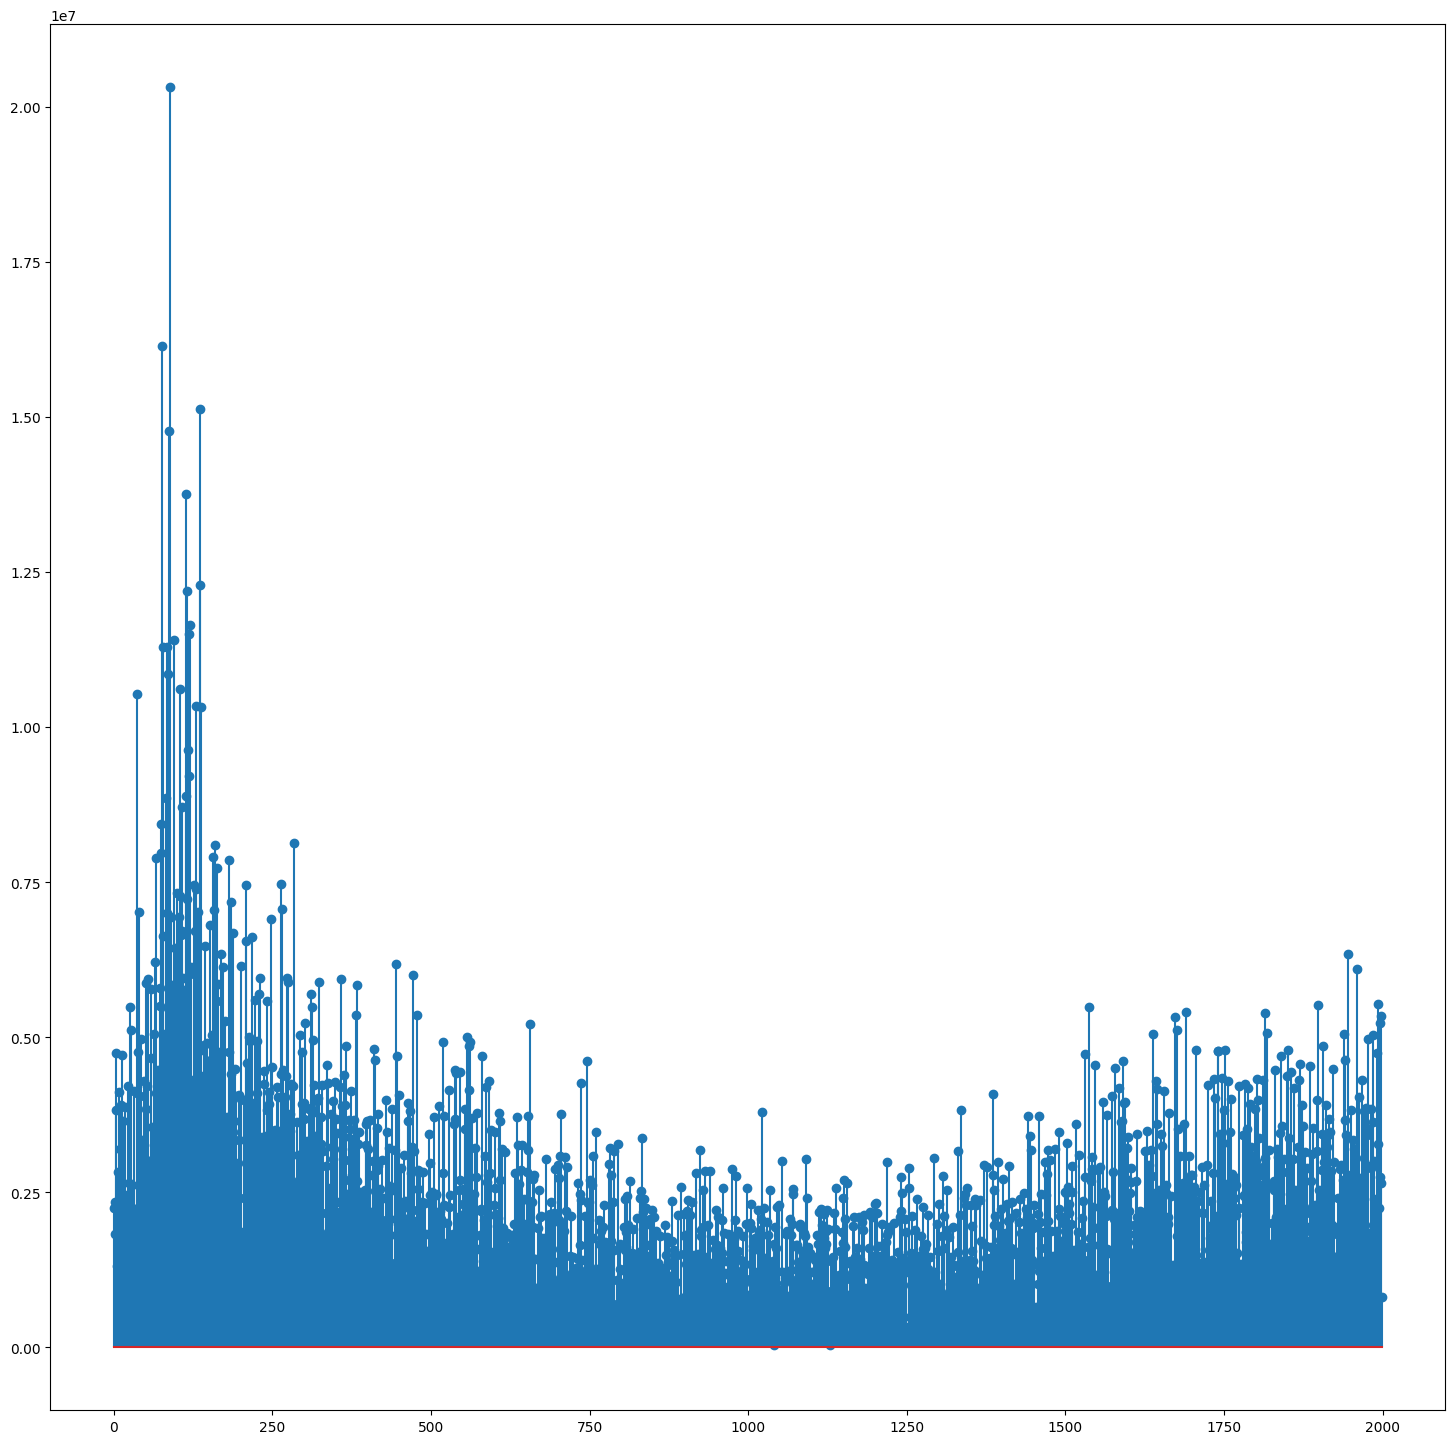

(88,)


In [ ]:
# compute the main frequency of the pattern by choosing a line in the image and using the FFT
fftfringe = np.abs(np.fft.fft(interfero[0,:])) # to be completed
plt.figure()
plt.stem(fftfringe)
plt.show()

freq = np.unravel_index(np.argmax(np.abs(fftfringe)), fftfringe.shape)
print(freq)

### Answer 3.5a
The frequency is equal to 88.

No, this is not the same frequency for all the considerd lines but as we can observe 88 is the most relevant frequency among all.

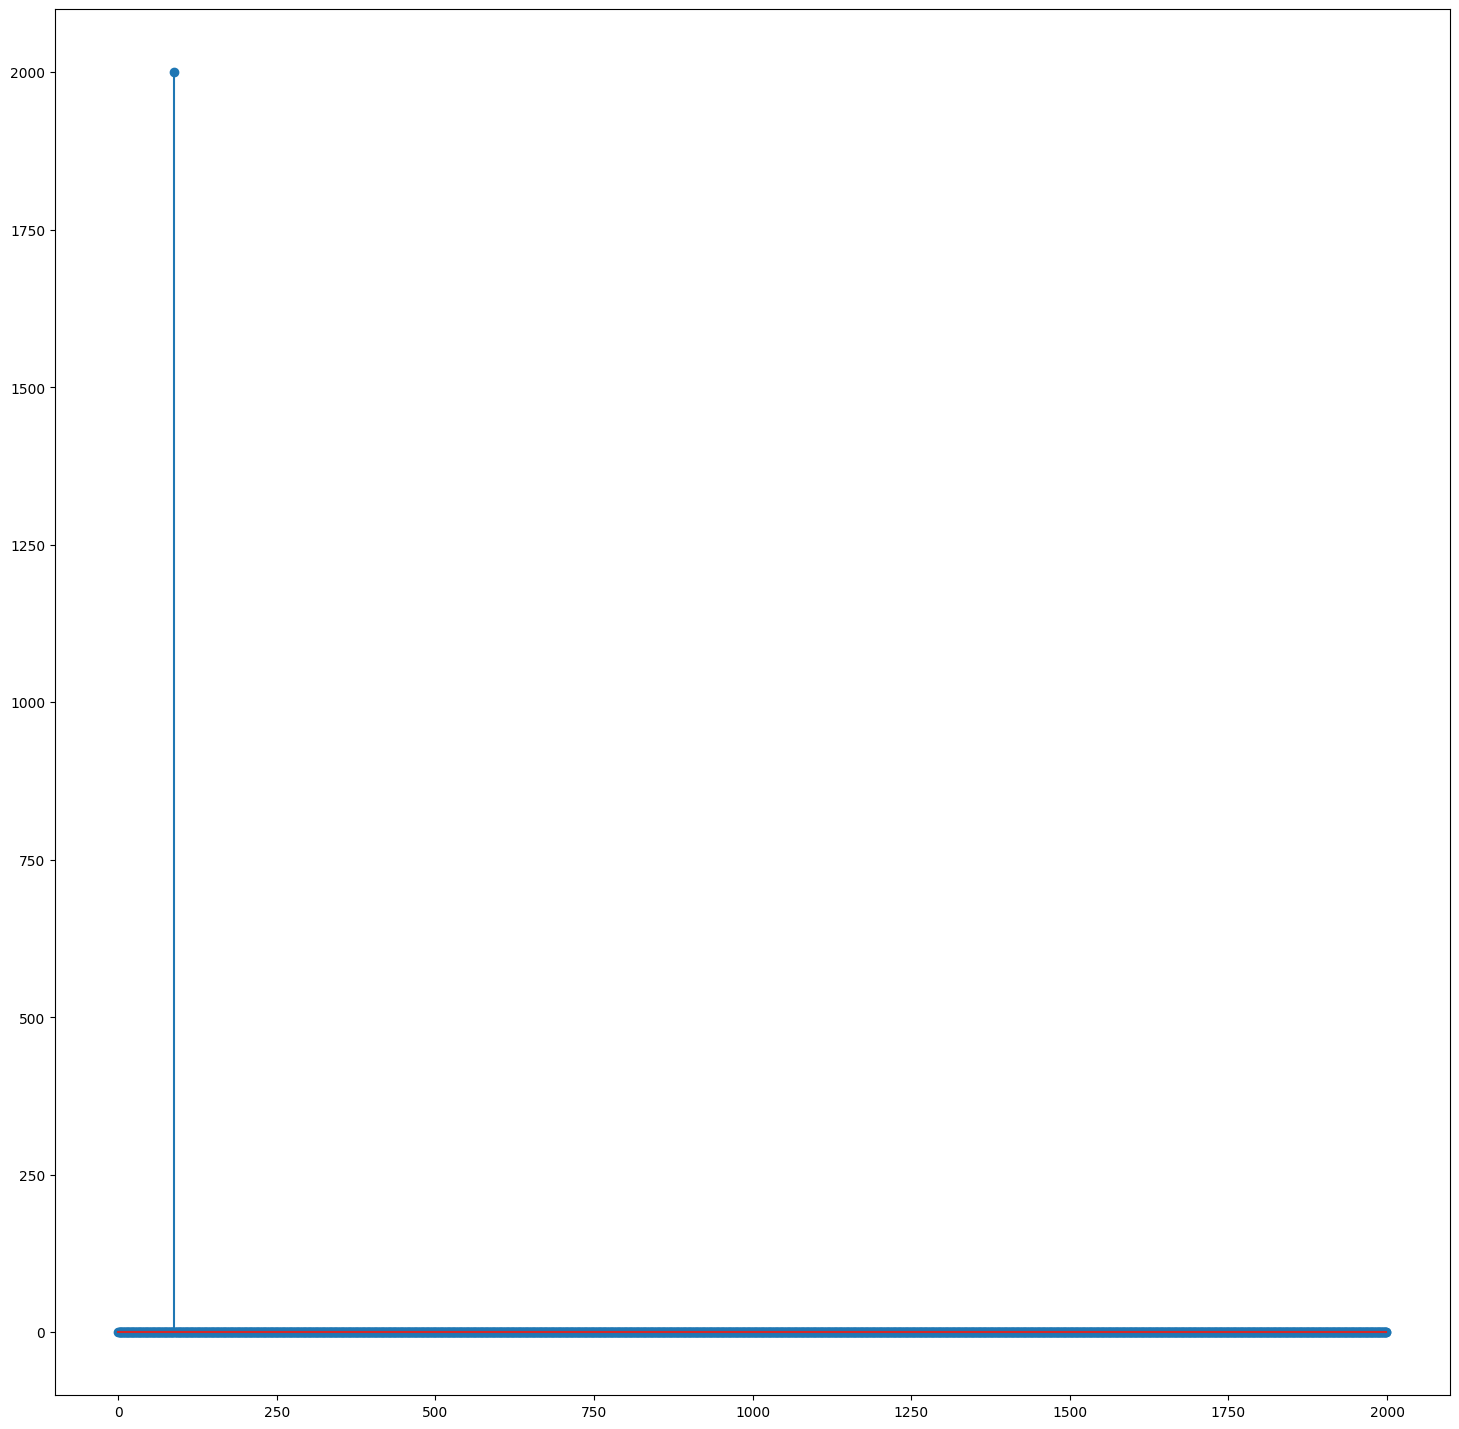

In [ ]:
N = interfero.shape[1]
n = np.arange(0,N)
onde = np.exp(1j*2*np.pi*n*freq/N)  # create a pure wave using the previously computed frequency freq
fonde = np.abs(np.fft.fft(onde))
plt.figure()
plt.stem(fonde)
plt.show()

In [ ]:
# suppress the pattern by multiplying the interferogram by the conjugate of the pure wave

imaslavefine= imaslaveroll*onde
interferofine= imamaitre*np.conjugate(imaslavefine)
mvalab.visuinterfero(np.angle(interferofine)+math.pi,0)

Output hidden; open in https://colab.research.google.com to view.

### Answer 3.5b
In the resulting interferogram, we can clearly see the crater of Mount Etna.
The fringes that are turned in direction of the sensor are narrower, while the ones facing the other side are larger. We can also now observe that they are orbital.

### Question 3.6: interferogram filtering
To improve the quality of the interferogram, some filtering can be applied to reduce the phase noise. Propose a suitable kernel by filling the code below.

How does the filtered interferogram look like?

### Answer 3.6
We use an averaging mask, to smooth the image i.e. reduce to a certain extent the noise.


In [ ]:
def interferogramme( tabvignette, tabvignette2, *therest) :
    """
    Computation of the complex interferogram between two images of the
    same size.
    By default, window size is set as 3x3 (dimx, dimy).
    It outputs a complex image, whose modulus is the coherence and whose phase
    is the interferometric phase.
    """

    dimx=3
    dimy=3

    if(len(therest)==1):
        dimx=therest[0]
        dimy=dimx

    if(len(therest)==2):
        dimx=therest[0]
        dimy=therest[1]

    nlig=np.size(tabvignette,0)
    ncol=np.size(tabvignette,1)

    if nlig != np.size(tabvignette2,0)  :
        print(u'les deux images doivent avoir la même taille (%d  et %d)'%(nlig, np.size(tabvignette2,0)))
        return 0

    if ncol != np.size(tabvignette2,1)  :
        print(u'les deux images doivent avoir la même taille')
        return 0

    interf= np.multiply(tabvignette, np.conj(tabvignette2))

    # part to be completed to compute a multi-look interfergram by averaging on a local window


    mask = np.ones((dimx,dimy))/(dimx*dimy) # to be completed
    interfiltr = signal.convolve2d(interf,mask,mode='same')

    den1 = np.sqrt(signal.convolve2d(np.square(np.abs(tabvignette)),mask,mode='same'))
    den2 = np.sqrt(signal.convolve2d(np.square(np.abs(tabvignette2)),mask,mode='same'))

    return interfiltr/(den1*den2+1e-12)

In [ ]:
imaslavefine= np.multiply(imaslaveroll,onde)
filtered_interferogram = interferogramme(imamaitre,imaslavefine)
mvalab.visusar(np.abs(filtered_interferogram))
mvalab.visuinterfero(np.angle(filtered_interferogram),0)

Output hidden; open in https://colab.research.google.com to view.

### Question 3.7
Can you apply the convolution directly on the interferometric phase image ?
What would happen in that case?

**Answer 3.7**
 This strategy is possible, however, it is not very useful, since we lose the modularity of the phase. The only way to properly average the phase is to do it over in a small window and using phase.

In [ ]:
angle_infer = np.angle(interferofine)
mask = np.ones((3,3))/9 # to be completed
interfiltr = signal.convolve2d(angle_infer,mask,mode='same')

mvalab.visuinterfero(interfiltr,0)

Output hidden; open in https://colab.research.google.com to view.